# Прогнозирование оттока клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры (более 0.59). Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Признаки:

RowNumber — индекс строки в данных

CustomerId — уникальный идентификатор клиента

Surname — фамилия

CreditScore — кредитный рейтинг

Geography — страна проживания

Gender — пол

Age — возраст

Tenure — количество недвижимости у клиента

Balance — баланс на счёте

NumOfProducts — количество продуктов банка, используемых клиентом

HasCrCard — наличие кредитной карты

IsActiveMember — активность клиента

EstimatedSalary — предполагаемая зарплата


Целевой признак:

Exited — факт ухода клиента

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split #импортируем функцию train_test_split из библиотеки sklearn 
from sklearn.metrics import r2_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score 
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve 

In [2]:
df=pd.read_csv("/datasets/Churn.csv") #прочитаем файл 
df.info() # изучим общую информацию по дата фрейму
df.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,15699461,Fiorentini,515,Spain,Male,35,10.0,176273.95,1,0,1,121277.78,0
96,97,15738721,Graham,773,Spain,Male,41,9.0,102827.44,1,0,1,64595.25,0
97,98,15693683,Yuille,814,Germany,Male,29,8.0,97086.40,2,1,1,197276.13,0
98,99,15604348,Allard,710,Spain,Male,22,8.0,0.00,2,0,0,99645.04,0


In [3]:
df.isnull().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

почти что 10% данных имеют пустое значение в признаке "количество недвижимости".

In [4]:
df_tenure=df.query('Tenure =="NaN"')
df_tenure

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


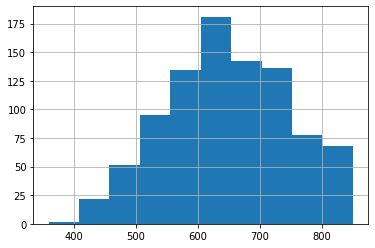

In [5]:
df_tenure['CreditScore'].hist()

In [6]:
df_tenure['Geography'].value_counts()

France     464
Spain      229
Germany    216
Name: Geography, dtype: int64

In [7]:
#заполним NaN на 0 
df['Tenure']=df['Tenure'].fillna(0)

In [8]:
#удалим столбцы id, row и surname, так как эти признаки нам не нужны
df = df.drop(['RowNumber','CustomerId','Surname'], axis=1)

In [9]:
#приведем к нижнему регистру название стобцов
df.columns=df.columns.str.lower()

In [10]:
#чтобы было по красоте, подкорректируем названия стобцов
df.columns=['credit_score','geography','gender','age','tenure','balance','num_of_products','has_cr_card','is_active_member','estimated_salary','exited']

In [11]:
df

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [12]:
columns=['tenure','balance','num_of_products','has_cr_card','is_active_member','estimated_salary']
for i in columns:
    df[i]=df[i].astype(int)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
credit_score        10000 non-null int64
geography           10000 non-null object
gender              10000 non-null object
age                 10000 non-null int64
tenure              10000 non-null int64
balance             10000 non-null int64
num_of_products     10000 non-null int64
has_cr_card         10000 non-null int64
is_active_member    10000 non-null int64
estimated_salary    10000 non-null int64
exited              10000 non-null int64
dtypes: int64(9), object(2)
memory usage: 859.5+ KB


# Вывод: 
Данные прошли предобработку. Добалили необходимые библиотеки, изучили общую информацию по датафрейму.

In [14]:
#Преобразовать категориальные признаки в численные поможет техника прямого кодирования, или отображения (англ. One-Hot Encoding, OHE).
df_ohe=pd.get_dummies(df, drop_first=True)
df_ohe

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0,1,1,1,101348,1,0,0,0
1,608,41,1,83807,1,0,1,112542,0,0,1,0
2,502,42,8,159660,3,1,0,113931,1,0,0,0
3,699,39,1,0,2,0,0,93826,0,0,0,0
4,850,43,2,125510,1,1,1,79084,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0,2,1,0,96270,0,0,0,1
9996,516,35,10,57369,1,1,1,101699,0,0,0,1
9997,709,36,7,0,1,0,1,42085,1,0,0,0
9998,772,42,3,75075,2,1,0,92888,1,1,0,1


In [15]:
#Разделим исходные данные на обучающую, валидационную и тестовую выборки. В ходе исследования изменила с 60-20-20 на 70-15-15
df_train, df_valid_30 = train_test_split(df_ohe, test_size=0.3, random_state=12345)
df_valid, df_test = train_test_split(df_valid_30, test_size=0.5, random_state=12345)

In [16]:
#создадим переменные для признаков и целевого признака для 3х выборок:
#для обучающей
features_train = df_train.drop(['exited'], axis=1)
target_train = df_train['exited']
#для валидационной
features_valid = df_valid.drop(['exited'], axis=1)
target_valid = df_valid['exited']
#для тестовой
features_test=df_test.drop(['exited'], axis=1)
target_test=df_test['exited']

In [17]:
#изучим выборки

print(features_train.shape)
print(target_train.shape)

print(features_valid.shape)
print(target_valid.shape)

print(features_test.shape)
print(target_test.shape)

(7000, 11)
(7000,)
(1500, 11)
(1500,)
(1500, 11)
(1500,)


In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 9716 to 4578
Data columns (total 12 columns):
credit_score         7000 non-null int64
age                  7000 non-null int64
tenure               7000 non-null int64
balance              7000 non-null int64
num_of_products      7000 non-null int64
has_cr_card          7000 non-null int64
is_active_member     7000 non-null int64
estimated_salary     7000 non-null int64
exited               7000 non-null int64
geography_Germany    7000 non-null uint8
geography_Spain      7000 non-null uint8
gender_Male          7000 non-null uint8
dtypes: int64(9), uint8(3)
memory usage: 567.4 KB


In [19]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 8606 to 142
Data columns (total 12 columns):
credit_score         1500 non-null int64
age                  1500 non-null int64
tenure               1500 non-null int64
balance              1500 non-null int64
num_of_products      1500 non-null int64
has_cr_card          1500 non-null int64
is_active_member     1500 non-null int64
estimated_salary     1500 non-null int64
exited               1500 non-null int64
geography_Germany    1500 non-null uint8
geography_Spain      1500 non-null uint8
gender_Male          1500 non-null uint8
dtypes: int64(9), uint8(3)
memory usage: 121.6 KB


In [20]:
#приведем численные признаки к одному масштабу. Один из методов масштабирования — стандартизация данных.
numeric = ['credit_score','age','tenure','balance','num_of_products','estimated_salary']
scaler = StandardScaler() #Создадим объект этой структуры и настроим его на обучающих данных
scaler.fit(features_train[numeric])
features_train[numeric]=scaler.transform(features_train[numeric])
features_valid[numeric]=scaler.transform(features_valid[numeric])
#features_test[numeric]=scaler.transform(features_test[numeric])

# Вывод:
Разделили исходные данные на обучающую, валидационную и тестовую выборки методом train_test_split в 2 подхода в пропорциях 3:1:1.
Проверили методом info() правильно ли разделена выборка.
Создали переменные для признаков и целевого признака для 3х выборок.
Привели численные признаки к одному масштабу с помощью стандартизации данных.

# 2. Исследование задачи

In [21]:
#Исследуем баланс классов
df_ohe['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

Наблюдается дисбаланс классов. Положительного класса почти в 4 раза меньше.
Сначала обучим модели с этим дисбалансом. 

По отдельности полнота и точность не слишком информативны. Нужно одновременно повышать показатели обеих. Или обратиться к новой метрике, которая их объединит.
Полнота и точность оценивают качество прогноза положительного класса с разных позиций. Recall описывает, как хорошо модель разобралась в особенностях этого класса и распознала его. Precision выявляет, не переусердствует ли модель, присваивая положительные метки.

recall=recall_score(target_valid,predicted_valid)
#Полнота выявляет, какую долю положительных среди всех ответов выделила модель. Обычно они на вес золота, и важно понимать, как хорошо модель их находит.
precision=precision_score(target_valid,predicted_valid)
#Точность определяет, как много отрицательных ответов нашла модель, пока искала положительные. Чем больше отрицательных, тем ниже точность.
f1=f1_score(target_valid, predicted_valid)

In [22]:
#ФУНКЦИЯ
#Исследуем качество разных моделей, меняя гиперпараметры. 

#для модели решающего дерева
#в цикле проверим гиперпараметр глубины дерева от 1 до 30, кратно 2

def model_quality_dtc(features_x,target_x,features_y,target_y, depth):
    depth_and_score=pd.DataFrame(columns=["depth", 'recall', 'precision','f1','auc_roc'])
    i=0
    model= DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_x, target_x) #обучим модель
    predicted_y=model.predict(features_y) #предскажем по валидационной выборке
    recall=recall_score(target_y,predicted_y) 
    precision=precision_score(target_y, predicted_y)
    f1=f1_score(target_y, predicted_y)
    probabilities_y = model.predict_proba(features_y)
    probabilities_one_y = probabilities_y[:, 1]
    auc_roc=roc_auc_score(target_y, probabilities_one_y )
    depth_and_score.loc[i]=[depth, recall, precision, f1, auc_roc]  #построим датафрейм с данными по accuracy на валидационной и тестовой выборке
    i+=1
    print(depth_and_score) 

In [23]:
#for depth in range(3,51,2):
    #model_quality_dtc(features_train,target_train,features_valid,target_valid, depth)

In [24]:
#для модели случайного леса 

def model_quality_rfc(features_x,target_x,features_y,target_y, estim, depth):
    estim_and_score=pd.DataFrame(columns=["estimators","max_depth",'recall', 'precision','f1','auc_roc'])
    i=0
    model= RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth=depth)
    model.fit(features_x, target_x) #обучим модель
    predicted_y=model.predict(features_y) #предскажем по валидационной выборке
    recall=recall_score(target_y,predicted_y) 
    precision=precision_score(target_y, predicted_y)
    f1=f1_score(target_y, predicted_y)
    probabilities_y = model.predict_proba(features_y)
    probabilities_one_y = probabilities_y[:, 1]
    auc_roc=roc_auc_score(target_y, probabilities_one_y )
    estim_and_score.loc[i]=[estim, depth, recall, precision, f1, auc_roc]  #построим датафрейм с данными по accuracy на валидационной и тестовой выборке
    i+=1
    print(estim_and_score)

In [25]:
#в цикле проверим качество модели для гиперпараметра количество оценщиков от 1 до 100, кратно 10
for estim in range(1,151,10):
    for depth in range (5,50,2):
        model_quality_rfc(features_train,target_train,features_valid,target_valid, estim, depth)

   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0        5.0  0.439739   0.733696  0.549898  0.781053
   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0        7.0  0.485342   0.628692  0.547794  0.785344
   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0        9.0  0.410423   0.673797  0.510121  0.750148
   estimators  max_depth   recall  precision        f1   auc_roc
0         1.0       11.0  0.47557   0.600823  0.530909  0.741205
   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0       13.0  0.504886   0.536332  0.520134  0.717938
   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0       15.0  0.469055   0.481605  0.475248  0.673654
   estimators  max_depth   recall  precision      f1   auc_roc
0         1.0       17.0  0.47557   0.462025  0.4687  0.684447
   estimators  max_depth    recall  precision        f1  auc_roc
0         1.0      

In [26]:
#для модели логистической регрессии 

def model_quality_lr(features_x,target_x,features_y,target_y):
    model = LogisticRegression(solver='liblinear', random_state=12345)
    model.fit(features_x, target_x) #обучим модель
    predicted_y=model.predict(features_y)
    recall=recall_score(target_y,predicted_y) 
    precision=precision_score(target_y, predicted_y)
    f1=f1_score(target_y, predicted_y)
    probabilities_y = model.predict_proba(features_y)
    probabilities_one_y = probabilities_y[:, 1]
    auc_roc=roc_auc_score(target_y, probabilities_one_y )
    print("Полнота:", recall)
    print("Точность:", precision)
    print("F1-мера:", f1)
    print("AUC-ROC:", auc_roc)

In [27]:
model_quality_lr(features_train,target_train,features_valid,target_valid)

Полнота: 0.2247557003257329
Точность: 0.5798319327731093
F1-мера: 0.323943661971831
AUC-ROC: 0.7751378153233711


# Вывод: 
Для 3х моделей были посчитаны оптимальные значения f1, методом перебора гиперпараметров. 

Для модели решающего дерева максимальное значение f1 0.577031 достигается при глубине дерева 9, при этом значение полноты 0.492823, а точности	0.695946.

Для модели случайного леса максимальное значение f1 0.571429 достигается при глубине дерева 9, количество оценциков 21, при этом значение полноты 0.435407, а точности 0.83105.

Для логистической регрессии F1-мера составила 0.33389544688026984, Полнота: 0.23684210526315788, Точность: 0.5657142857142857

Ни одна модель не достигла требуемого показателя f1, так как наблюдается дисбаланс классов.

В дополнении можно было бы построить ROC-кривые и исследовать матрицу ошибок для исходных данных.

# 3. Борьба с дисбалансом

In [28]:
#сбалансируем классы для модели дерева решений 
def model_quality_dtc_balanced(features_x,target_x,features_y,target_y, depth):
    depth_and_score=pd.DataFrame(columns=["depth", 'recall', 'precision','f1','auc_roc'])
    i=0
    model= DecisionTreeClassifier(class_weight='balanced', random_state=12345, max_depth=depth)
    model.fit(features_x, target_x) #обучим модель
    predicted_y=model.predict(features_y) #предскажем по валидационной выборке
    recall=recall_score(target_y,predicted_y) 
    precision=precision_score(target_y, predicted_y)
    f1=f1_score(target_y, predicted_y)
    probabilities_y = model.predict_proba(features_y)
    probabilities_one_y = probabilities_y[:, 1]
    auc_roc=roc_auc_score(target_y, probabilities_one_y )
    depth_and_score.loc[i]=[depth, recall, precision, f1, auc_roc]  #построим датафрейм с данными по accuracy на валидационной и тестовой выборке
    i+=1
    print(depth_and_score) 

In [29]:
#подберем гиперпараметры для того, чтобы достичь макс f1
for depth in range(3,31,2):
    model_quality_dtc_balanced(features_train,target_train,features_valid,target_valid, depth)

   depth    recall  precision        f1   auc_roc
0    3.0  0.677524   0.450216  0.540962  0.800072
   depth    recall  precision        f1  auc_roc
0    5.0  0.693811   0.518248  0.593315  0.83681
   depth   recall  precision        f1  auc_roc
0    7.0  0.71987   0.444668  0.549751  0.80599
   depth    recall  precision        f1   auc_roc
0    9.0  0.703583   0.442623  0.543396  0.790192
   depth    recall  precision        f1   auc_roc
0   11.0  0.615635   0.422819  0.501326  0.723154
   depth    recall  precision        f1   auc_roc
0   13.0  0.579805   0.429952  0.493759  0.700929
   depth    recall  precision        f1   auc_roc
0   15.0  0.543974    0.46648  0.502256  0.692543
   depth    recall  precision        f1   auc_roc
0   17.0  0.485342   0.474522  0.479871  0.673473
   depth    recall  precision        f1   auc_roc
0   19.0  0.485342   0.480645  0.482982  0.675361
   depth    recall  precision        f1   auc_roc
0   21.0  0.472313   0.461783  0.466989  0.665327
   dep

Максимальное значение f1 у модели с глубиной 5 - 0,59

In [30]:
#сбалансируем классы для модели случаного дерева 
def model_quality_rfc_balanced(features_x,target_x,features_y,target_y, estim, depth):
    estim_and_score=pd.DataFrame(columns=["estimators","max_depth",'recall', 'precision','f1','auc_roc'])
    i=0
    model= RandomForestClassifier(class_weight='balanced', random_state=12345, n_estimators=estim, max_depth=depth)
    model.fit(features_x, target_x) #обучим модель
    predicted_y=model.predict(features_y) #предскажем по валидационной выборке
    recall=recall_score(target_y,predicted_y) 
    precision=precision_score(target_y, predicted_y)
    f1=f1_score(target_y, predicted_y)
    probabilities_y = model.predict_proba(features_y)
    probabilities_one_y = probabilities_y[:, 1]
    auc_roc=roc_auc_score(target_y, probabilities_one_y )
    estim_and_score.loc[i]=[estim, depth, recall, precision, f1, auc_roc]  #построим датафрейм с данными по accuracy на валидационной и тестовой выборке
    i+=1
    print(estim_and_score)

In [31]:
#подберем гиперпараметры для того, чтобы достичь макс f1
for estim in range(1,151,10):
    for depth in range (5,50,2):
        model_quality_rfc_balanced(features_train,target_train,features_valid,target_valid, estim, depth)

   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0        5.0  0.625407   0.498701  0.554913  0.800876
   estimators  max_depth    recall  precision        f1  auc_roc
0         1.0        7.0  0.703583   0.393443  0.504673  0.75582
   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0        9.0  0.726384   0.449597  0.555417  0.788035
   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0       11.0  0.651466     0.4662  0.543478  0.764159
   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0       13.0  0.586319   0.453401  0.511364  0.722451
   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0       15.0  0.459283   0.447619  0.453376  0.659721
   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0       17.0  0.491857   0.496711  0.494272  0.684943
   estimators  max_depth    recall  precision       f1  auc_roc
0         1.0 

In [32]:
# сбалансируем классы для модели логистической регрессии 

def model_quality_lr_balanced(features_x,target_x,features_y,target_y):
    model = LogisticRegression(class_weight='balanced',solver='liblinear', random_state=12345)
    model.fit(features_x, target_x) #обучим модель
    predicted_y=model.predict(features_y)
    recall=recall_score(target_y,predicted_y) 
    precision=precision_score(target_y, predicted_y)
    f1=f1_score(target_y, predicted_y)
    probabilities_y = model.predict_proba(features_y)
    probabilities_one_y = probabilities_y[:, 1]
    auc_roc=roc_auc_score(target_y, probabilities_one_y )
    print("Полнота:", recall)
    print("Точность:", precision)
    print("F1-мера:", f1)
    print("AUC-ROC:", auc_roc)

In [33]:
model_quality_lr_balanced(features_train,target_train,features_valid,target_valid)

Полнота: 0.7296416938110749
Точность: 0.3855421686746988
F1-мера: 0.5045045045045046
AUC-ROC: 0.7792251761769933


мы получили максимальное значение f1 при том же гиперпараметре ( глубина 7) у модели дерева решений после использования взвешивания классов, 0,5576 вместо 0,5503.
макс значение f1 до взвешивания классов у модели случаного леса 0.54102 - для этих же гиперпараметров (оценцики 31, глубина 9) после балансирования классов показатель f1 увеличился до 0,59!

In [34]:
# Увеличим выборку, проведем upsampling:

# Разделим обучающую выборку на отрицательные и положительные объекты
features_zeros = features_train[target_train==0]
features_ones = features_train[target_train==1]
target_zeros = target_train[target_train==0]
target_ones = target_train[target_train==1]
print(features_zeros.shape)
print(features_ones.shape)
print(target_zeros.shape)
print(target_ones.shape)

(5589, 11)
(1411, 11)
(5589,)
(1411,)


In [35]:
# Скопируем несколько раз положительные объекты
# С учётом полученных данных создадим новую обучающую выборку

features_upsampled = pd.concat([features_zeros] + [features_ones] * 5)
target_upsampled = pd.concat([target_zeros] + [target_ones] * 5)

# Перемешаем данные
features_upsampled, target_upsampled=shuffle(features_upsampled, target_upsampled, random_state=12345)

In [36]:
print(features_upsampled.shape)
print(target_upsampled.shape)

(12644, 11)
(12644,)


In [37]:
print(target_upsampled.shape)

(12644,)


In [38]:
# Разделим валидационную выборку на отрицательные и положительные объекты
features_zeros_valid = features_valid[target_valid==0]
features_ones_valid = features_valid[target_valid==1]
target_zeros_valid = target_valid[target_valid==0]
target_ones_valid = target_valid[target_valid==1]
print(features_zeros_valid.shape)
print(features_ones_valid.shape)
print(target_zeros_valid.shape)
print(target_ones_valid.shape)

(1193, 11)
(307, 11)
(1193,)
(307,)


In [39]:
# Скопируем несколько раз положительные объекты
# С учётом полученных данных создадим новую валидационную выборку

features_upsampled_valid = pd.concat([features_zeros_valid] + [features_ones_valid] * 5)
target_upsampled_valid = pd.concat([target_zeros_valid] + [target_ones_valid] * 5)

# Перемешаем данные
features_upsampled_valid, target_upsampled_valid=shuffle(features_upsampled_valid, target_upsampled_valid, random_state=12345)

In [40]:
features_zeros_test = features_test[target_test==0]
features_ones_test = features_test[target_test==1]
target_zeros_test = target_test[target_test==0]
target_ones_test = target_test[target_test==1]
print(features_zeros_test.shape)
print(features_ones_test.shape)
print(target_zeros_test.shape)
print(target_ones_test.shape)

(1181, 11)
(319, 11)
(1181,)
(319,)


In [41]:
# Скопируем несколько раз положительные объекты
# С учётом полученных данных создадим новую тестовую выборку

features_upsampled_test = pd.concat([features_zeros_test] + [features_ones_test] * 5)
target_upsampled_test = pd.concat([target_zeros_test] + [target_ones_test] * 5)

# Перемешаем данные
features_upsampled_test, target_upsampled_test=shuffle(features_upsampled_test, target_upsampled_test, random_state=12345)

In [42]:
print(features_upsampled_test.shape)
print(target_upsampled_test.shape)

(2776, 11)
(2776,)


In [43]:
#Исследуем качество разных моделей, меняя гиперпараметры, на увеличенной выборке.

#для модели решающего дерева
#в цикле проверим гиперпараметр глубины дерева от 1 до 30, кратно 2
for depth in range(1,31,2):
    model_quality_dtc(features_upsampled,target_upsampled,features_upsampled_valid,target_upsampled_valid, depth)

   depth    recall  precision       f1   auc_roc
0    1.0  0.732899   0.741107  0.73698  0.701739
   depth    recall  precision        f1   auc_roc
0    3.0  0.771987   0.747163  0.759372  0.793643
   depth    recall  precision        f1   auc_roc
0    5.0  0.824104   0.767597  0.794848  0.831514
   depth   recall  precision        f1   auc_roc
0    7.0  0.80456   0.780657  0.792429  0.826974
   depth    recall  precision        f1   auc_roc
0    9.0  0.739414   0.781142  0.759705  0.790398
   depth    recall  precision        f1   auc_roc
0   11.0  0.697068   0.800898  0.745385  0.764816
   depth    recall  precision        f1   auc_roc
0   13.0  0.618893   0.801688  0.698529  0.723452
   depth    recall  precision        f1   auc_roc
0   15.0  0.543974   0.819431  0.653876  0.704619
   depth   recall  precision        f1   auc_roc
0   17.0  0.52443   0.825641  0.641434  0.691098
   depth    recall  precision        f1   auc_roc
0   19.0  0.517915   0.832461  0.638554  0.691707
   dep

показатель f1 после увеличения выборки уменьшился, но остался на той же глубине 7.

In [44]:
#посчитаем для модели со сбалансированными классами и расширенной выборкой
for depth in range(1,31,2):
    model_quality_dtc_balanced(features_upsampled,target_upsampled,features_upsampled_valid,target_upsampled_valid, depth)

   depth    recall  precision        f1   auc_roc
0    1.0  0.618893   0.794979  0.695971  0.706764
   depth    recall  precision        f1   auc_roc
0    3.0  0.677524   0.803709  0.735242  0.800072
   depth    recall  precision        f1  auc_roc
0    5.0  0.693811    0.84323  0.761258  0.83681
   depth    recall  precision        f1   auc_roc
0    7.0  0.723127   0.800288  0.759754  0.808644
   depth    recall  precision        f1   auc_roc
0    9.0  0.703583   0.798226  0.747922  0.788953
   depth    recall  precision        f1  auc_roc
0   11.0  0.612378   0.786611  0.688645   0.7213
   depth    recall  precision        f1   auc_roc
0   13.0  0.576547   0.794434  0.668177  0.699649
   depth    recall  precision        f1   auc_roc
0   15.0  0.521173   0.818833  0.636943  0.686334
   depth    recall  precision        f1   auc_roc
0   17.0  0.488599   0.819672  0.612245  0.673499
   depth   recall  precision        f1   auc_roc
0   19.0  0.47557   0.828604  0.604305  0.674266
   dep

Максимальное значение f1 снизилось на сбалансированной (0,79) и расширенной выборке по сравнению с просто расширенной выборкой (0,76).

In [45]:
#построим функцию для постотроения графиков полнота-точность для модели, показавшей лучшее значение f1. Чем выше кривая, тем лучше модель.

def model_quality_dtc_plt(features_x,target_x,features_y,target_y, depth):
    model= DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_x, target_x) #обучим модель
    predicted_y=model.predict(features_y) #предскажем по валидационной выборке
    recall=recall_score(target_y,predicted_y) 
    precision=precision_score(target_y, predicted_y)
    probabilities_y = model.predict_proba(features_y)
    probabilities_one_y = probabilities_y[:, 1]
    precision, recall, thresholds = precision_recall_curve(target_y, probabilities_y[:, 1])
    plt.figure(figsize=(6, 6))
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    print("График для глубины", depth)
    plt.title('Кривая Precision-Recall')
    plt.show()

    fpr, tpr, thresholds = roc_curve(target_y, probabilities_one_y)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])# < применим функции plt.xlim() и plt.ylim(), чтобы
    plt.ylim([0.0, 1.0])#   установить границы осей от 0 до 1 >
    plt.xlabel('False Positive Rate')# < применим функции plt.xlabel() и plt.ylabel(), чтобы
    plt.ylabel('True Positive Rate')#   подписать оси "False Positive Rate" и "True Positive Rate" >
    plt.title('ROC-кривая')# < добавим к графику заголовок "ROC-кривая" функцией plt.title() >
    plt.show()

График для глубины 5


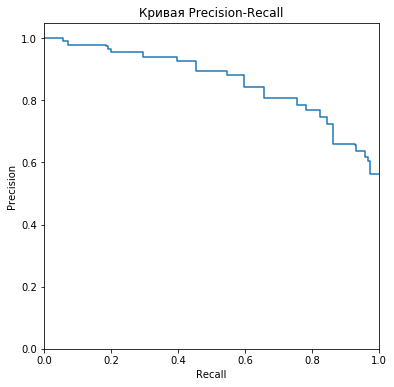

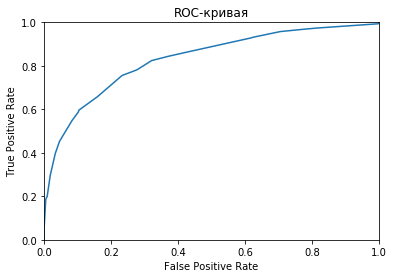

In [46]:
model_quality_dtc_plt(features_upsampled,target_upsampled,features_upsampled_valid,target_upsampled_valid, 5)

In [47]:
#для модели случайного леса c расширенной выборкой
#в цикле проверим качество модели для гиперпараметра количество оценщиков от 1 до 100, кратно 10
for estim in range(1,151,10):
    for depth in range (1,30,2):
        model_quality_rfc(features_upsampled, target_upsampled,features_upsampled_valid,target_upsampled_valid, estim, depth)

   estimators  max_depth  recall  precision       f1   auc_roc
0         1.0        1.0     1.0   0.562683  0.72015  0.566261
   estimators  max_depth   recall  precision        f1   auc_roc
0         1.0        3.0  0.81759   0.727115  0.769703  0.723885
   estimators  max_depth   recall  precision        f1   auc_roc
0         1.0        5.0  0.76873   0.763754  0.766234  0.798912
   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0        7.0  0.801303   0.765401  0.782941  0.806149
   estimators  max_depth  recall  precision        f1   auc_roc
0         1.0        9.0  0.7557   0.773333  0.764415  0.790885
   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0       11.0  0.693811   0.798351  0.742419  0.759284
   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0       13.0  0.638436   0.786517  0.704782  0.723392
   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0       15.0

In [48]:
#для модели случайного леса c расширенной выборкой и сбалансированными классами
for estim in range(1,151,10):
    for depth in range (1,50,2):
        model_quality_rfc_balanced(features_upsampled, target_upsampled,features_upsampled_valid,target_upsampled_valid, estim, depth)

   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0        1.0  0.140065   0.959821  0.244457  0.566261
   estimators  max_depth   recall  precision        f1   auc_roc
0         1.0        3.0  0.81759   0.727115  0.769703  0.723885
   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0        5.0  0.618893   0.835532  0.711078  0.798912
   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0        7.0  0.726384   0.808557  0.765271  0.806149
   estimators  max_depth   recall  precision        f1   auc_roc
0         1.0        9.0  0.71987   0.803052  0.759189  0.800355
   estimators  max_depth    recall  precision       f1   auc_roc
0         1.0       11.0  0.628664   0.790336  0.70029  0.715052
   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0       13.0  0.661238   0.799213  0.723708  0.744211
   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0   

применение расширения выборки и балансирования классов на расширенной выборке у модели случайного леса значение F1 в среднем ниже, чем у случайного леса с расширенной выборкой. Лучшее значение f1 достигается у случайного леса на расширенной выборке с гиперпараметрами 41 оценщик и глубина 7 - 0,8113.

In [49]:
#построим функцию для постотроения графиков полнота-точность для модели, показавшей лучшее значение f1. Чем выше кривая, тем лучше модель.

def model_quality_rfc_plt(features_x,target_x,features_y,target_y, estim, depth):
    model= RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth=depth)
    model.fit(features_x, target_x) #обучим модель
    predicted_y=model.predict(features_y) #предскажем по валидационной выборке
    recall=recall_score(target_y,predicted_y) 
    precision=precision_score(target_y, predicted_y)
    probabilities_y = model.predict_proba(features_y)
    probabilities_one_y = probabilities_y[:, 1]
    precision, recall, thresholds = precision_recall_curve(target_y, probabilities_y[:, 1])
    plt.figure(figsize=(6, 6))
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    print("График количества оценщиков", estim,", для глубины ", depth)
    plt.title('Кривая Precision-Recall')
    plt.show()
    fpr, tpr, thresholds = roc_curve(target_y, probabilities_one_y)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])# < применим функции plt.xlim() и plt.ylim(), чтобы
    plt.ylim([0.0, 1.0])#   установить границы осей от 0 до 1 >
    plt.xlabel('False Positive Rate')# < применим функции plt.xlabel() и plt.ylabel(), чтобы
    plt.ylabel('True Positive Rate')#   подписать оси "False Positive Rate" и "True Positive Rate" >
    plt.title('ROC-кривая')# < добавим к графику заголовок "ROC-кривая" функцией plt.title() >
    plt.show()


График количества оценщиков 41 , для глубины  7


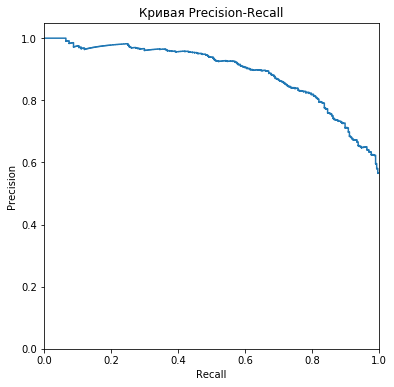

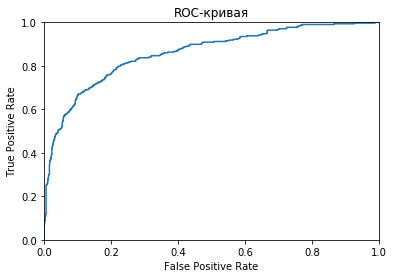

In [50]:
model_quality_rfc_plt(features_upsampled, target_upsampled,features_upsampled_valid,target_upsampled_valid, 41, 7)

In [51]:
# для модели логистической регрессии
model_quality_lr(features_upsampled, target_upsampled,features_upsampled_valid,target_upsampled_valid)

Полнота: 0.7980456026058632
Точность: 0.7278669043374926
F1-мера: 0.7613424487259168
AUC-ROC: 0.7797384853556713


In [52]:
# Уменьшим выборку, проведем downsampling:
#обучающую выборку уже разделили на отрицательные и положительные объекты на предыдущем upsampling 

In [53]:
#Случайным образом отбросить часть из отрицательных объектов при помощи метода sample()
#С учётом полученных данных создадим новую обучающую выборку
features_downsampled=pd.concat([features_zeros.sample(frac=0.22, random_state=12345)]+[features_ones])
target_downsampled=pd.concat([target_zeros.sample(frac=0.22, random_state=12345)]+[target_ones])
#Перемешаем данные
features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)

In [54]:
print(features_downsampled.shape)
print(target_downsampled.shape)

(2641, 11)
(2641,)


In [55]:
#Случайным образом отбросить часть из отрицательных объектов при помощи метода sample()
#С учётом полученных данных создадим новую обучающую выборку
features_downsampled_valid=pd.concat([features_zeros_valid.sample(frac=0.22, random_state=12345)]+[features_ones_valid])
target_downsampled_valid=pd.concat([target_zeros_valid.sample(frac=0.22, random_state=12345)]+[target_ones_valid])
#Перемешаем данные
features_downsampled_valid, target_downsampled_valid = shuffle(features_downsampled_valid, target_downsampled_valid, random_state=12345)

In [56]:
#Исследуем качество разных моделей, меняя гиперпараметры, на уменьшенной выборке.

#для модели решающего дерева
#в цикле проверим гиперпараметр глубины дерева от 1 до 30, кратно 2
for depth in range(1,31,2):
    model_quality_dtc(features_downsampled, target_downsampled,features_downsampled_valid,target_downsampled_valid, depth)

   depth    recall  precision        f1   auc_roc
0    1.0  0.732899   0.735294  0.734095  0.711869
   depth    recall  precision        f1   auc_roc
0    3.0  0.771987   0.740625  0.755981  0.792992
   depth   recall  precision        f1   auc_roc
0    5.0  0.80456   0.774295  0.789137  0.828549
   depth    recall  precision        f1   auc_roc
0    7.0  0.801303    0.76161  0.780952  0.804734
   depth    recall  precision        f1  auc_roc
0    9.0  0.716612   0.718954  0.717781  0.76367
   depth    recall  precision        f1   auc_roc
0   11.0  0.729642   0.722581  0.726094  0.708699
   depth    recall  precision        f1   auc_roc
0   13.0  0.736156   0.689024  0.711811  0.690597
   depth    recall  precision        f1   auc_roc
0   15.0  0.713355   0.684375  0.698565  0.664762
   depth    recall  precision        f1   auc_roc
0   17.0  0.739414   0.702786  0.720635  0.686283
   depth    recall  precision        f1   auc_roc
0   19.0  0.742671   0.688822  0.714734  0.678103
   d

График для глубины 7


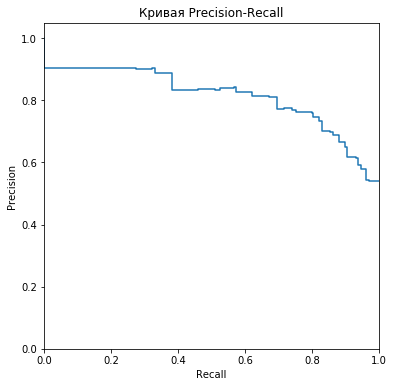

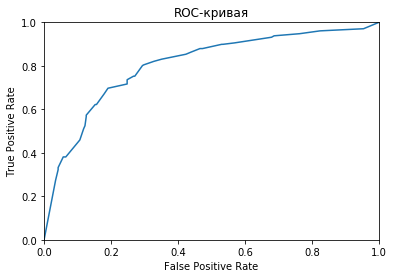

In [57]:
model_quality_dtc_plt(features_downsampled, target_downsampled,features_downsampled_valid,target_downsampled_valid, 7)

In [58]:
#для модели случайного леса 
#в цикле проверим качество модели для гиперпараметра количество оценщиков от 1 до 100, кратно 10

for estim in range(1,151,10):
    for depth in range (10,51,2):
        model_quality_rfc(features_downsampled, target_downsampled,features_downsampled_valid,target_downsampled_valid, estim, depth)

   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0       10.0  0.677524   0.729825  0.702703  0.718166
   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0       12.0  0.700326   0.707237  0.703764  0.692848
   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0       14.0  0.690554   0.706667  0.698517  0.679918
   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0       16.0  0.693811   0.707641  0.700658  0.682212
   estimators  max_depth    recall  precision        f1  auc_roc
0         1.0       18.0  0.710098   0.712418  0.711256  0.68711
   estimators  max_depth    recall  precision        f1  auc_roc
0         1.0       20.0  0.710098   0.712418  0.711256  0.68711
   estimators  max_depth    recall  precision        f1  auc_roc
0         1.0       22.0  0.710098   0.712418  0.711256  0.68711
   estimators  max_depth    recall  precision        f1  auc_roc
0         1.0    

График количества оценщиков 21 , для глубины  5


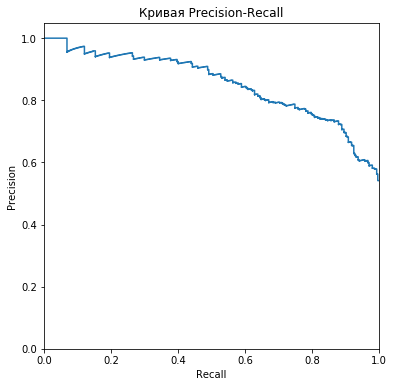

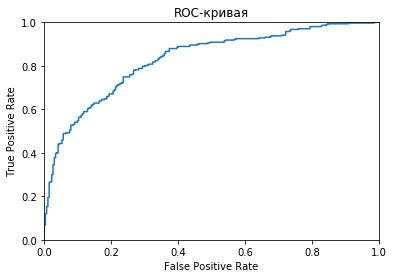

In [59]:
model_quality_rfc_plt(features_downsampled, target_downsampled,features_downsampled_valid,target_downsampled_valid, 21, 5)

In [60]:
#для модели случайного леса c уменьшенной выборкой и сбалансированными классами
for estim in range(1,151,10):
    for depth in range (5,50,2):
        model_quality_rfc_balanced(features_downsampled, target_downsampled,features_downsampled_valid,target_downsampled_valid, estim, depth)

   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0        5.0  0.700326   0.776173  0.736301  0.773355
   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0        7.0  0.641694   0.775591  0.702317  0.761506
   estimators  max_depth    recall  precision       f1   auc_roc
0         1.0        9.0  0.684039   0.739437  0.71066  0.727889
   estimators  max_depth   recall  precision       f1   auc_roc
0         1.0       11.0  0.70684    0.70684  0.70684  0.698859
   estimators  max_depth    recall  precision        f1  auc_roc
0         1.0       13.0  0.687296   0.722603  0.704508  0.68747
   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0       15.0  0.703583   0.701299  0.702439  0.671837
   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0       17.0  0.723127   0.735099  0.729064  0.708892
   estimators  max_depth    recall  precision        f1   auc_roc
0         1.0     

In [61]:
model_quality_lr(features_downsampled, target_downsampled,features_downsampled_valid,target_downsampled_valid)

Полнота: 0.7687296416938111
Точность: 0.7173252279635258
F1-мера: 0.7421383647798742
AUC-ROC: 0.7712907476937613


# Вывод: 
upsampling позволяет поднять показатель f1 до 0,81 на модели случайного леса при гиперпараметрах estimators 41, depth 7. показатель f1 на расширенной выборке и со сбалансированными классами чуть ниже.
у модели дерева решений максимальное значение  f1 при расширенной выборке с глубиной 5 - 0,59.
downsampling позволяет поднять показатель f1 только до 0,78, при балансировании классов и сокращении выборки показатель f1 чуть выше.
У логистической регрессии значение на расширенной выборке - 0.76, на сокращенной 0,74.

# 4. Тестирование модели

Проведем тестирование моделей показавших лучший результат

In [62]:
model_quality_rfc(features_upsampled,target_upsampled,features_upsampled_test,target_upsampled_test, 41, 7)

   estimators  max_depth    recall  precision        f1   auc_roc
0        41.0        7.0  0.520376   0.553333  0.536349  0.471665


In [63]:
#для модели решающего дерева с гиперпараметром глубины дерева 5
model_quality_dtc(features_upsampled, target_upsampled,features_upsampled_test,target_upsampled_test, 5)

   depth  recall  precision        f1   auc_roc
0    5.0  0.9279   0.640415  0.757808  0.616173


In [64]:
#для модели логистической регрессии 
model_quality_lr(features_upsampled, target_upsampled,features_upsampled_test,target_upsampled_test)

Полнота: 1.0
Точность: 0.5745677233429395
F1-мера: 0.7298101121024938
AUC-ROC: 0.4972859194296317


# Вывод: 
Для 3х моделей были посчитаны оптимальные значения f1 перебором гиперпараметров. 
Для модели решающего дерева максимальное значение f1 достигается при глубине дерева 5 на расширенной выборке  0.794848,  при этом значение полноты 0.824104, а точности	0.767597, AUC-ROC: 0.831514. на тестовой выборке данная модель достигла необходимого уровна f1 0.757808.
Для модели случайного леса максимальное значение f1 0.8113 достигается при глубине дерева 7, количество оценциков 41. на тестовой выборке эта модель показала полноту 0.520376, точность   0.553333, f1  0.536349,  AUC-ROC: 0.471665. Нужного показателя не достигла.
Для логистической регрессии на расширенной выборке F1-мера составила 0.7613, Полнота: 0.7980, Точность: 0.72786, AUC-ROC: 0.7797. На тестовой выборке следующие результаты: Полнота 1.0, Точность 0.5745, F1-мера: 0.7298, AUC-ROC: 0.497285. 

Ни одна модель не достигла требуемого показателя f1, без ликвидации дисбаланса классов.

